# **SETUP**

### **Imports**

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
!pip install adabound
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import os
import numpy as np
import pickle
import yaml
import random
import spacy
import re
import json
import operator
import time
import adabound

In [89]:
from xml.etree.ElementTree import parse
from pytorch_pretrained_bert import BertModel, BertTokenizer

In [90]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.nn import init
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

### **Constants**

In [91]:
PAD = '<pad>'
UNK = '<unk>'
ASPECT = '<aspect>'

PAD_INDEX = 0
UNK_INDEX = 1
ASPECT_INDEX = 2

INF = 1e9

# **CLASSES**

### **Data**

In [92]:
class ABSADataset(Dataset):

    def __init__(self, path, input_list):
        super(ABSADataset, self).__init__()
        data = np.load(path)
        self.data = {}
        for key, value in data.items():
            self.data[key] = torch.tensor(value).long()
        self.len = self.data['label'].size(0)
        self.input_list = input_list

    def __getitem__(self, index):
        return_value = []
        for input in self.input_list:
            return_value.append(self.data[input][index])
        return_value.append(self.data['label'][index])
        return return_value

    def __len__(self):
        return self.len

In [93]:
class Vocab(object):

    def __init__(self):
        self._count_dict = dict()
        self._predefined_list = [PAD, UNK, ASPECT]

    def add(self, word):
        if word in self._count_dict:
            self._count_dict[word] += 1
        else:
            self._count_dict[word] = 1

    def add_list(self, words):
        for word in words:
            self.add(word)

    def get_vocab(self, max_size=None, min_freq=0):
        # 
        sorted_words = sorted(self._count_dict.items(), key=operator.itemgetter(1), reverse=True)
        word2index = {}
        for word in self._predefined_list:
            word2index[word] = len(word2index)
        for word, freq in sorted_words:
            if word in word2index:
                continue
            if (max_size is not None and len(word2index) >= max_size) or freq < min_freq:
                word2index[word] = word2index[UNK]
            else:
                word2index[word] = len(word2index)
        index2word = {}
        index2word[word2index[UNK]] = UNK
        for word, index in word2index.items():
            if index == word2index[UNK]:
                continue
            else:
                index2word[index] = word
        return word2index, index2word

### **Model**

In [96]:
class Bert(nn.Module):

    def __init__(self, bert, bert_size, dropout, num_categories):
        super(Bert, self).__init__()
        self.bert = bert
        self.bert_size = bert_size
        # self.aspect_transform = nn.Sequential(
        #     nn.Linear(bert_size, capsule_size),
        #     nn.Dropout(dropout)
        # )
        # self.sentence_transform = nn.Sequential(
        #     nn.Linear(bert_size, capsule_size),
        #     nn.Dropout(dropout)
        # )
        
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(bert_size, num_categories)


    def forward(self, bert_token, bert_segment):
        # BERT encoding
        _, pooled_layout = self.bert(bert_token, bert_segment, output_all_encoded_layers=False)
        pooled_layout = self.dropout(pooled_layout)
        logits = self.dense(pooled_layout)
        return logits

# **FUNCTIONS**

In [97]:
def parse_sentence_term(path, lowercase=False):
    # parse each sentence into a tree by built-in xml function
    tree = parse(path)
    
    # from here down parse each sentence to 
    # '[text], [term], [polarity], [from], [to]' with '_split_' inbetween,
    # then append to data list. 
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = text + split_char + term + split_char + polarity + split_char + start + split_char + end
            data.append(piece)
    return data

In [98]:
def category_filter(data, remove_list):
    # remove conflicts, only allows polarity 'positive', 'neutral', 'negative'
    remove_set = set(remove_list)
    filtered_data = []
    for text in data:
        if not text.split('__split__')[2] in remove_set:
            filtered_data.append(text)
    return filtered_data

In [99]:
def check(x):
    return len(x) >= 1 and not x.isspace()

In [100]:
def tokenizer(text):
    tokens = [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]
    return list(filter(check, tokens))

In [101]:
def build_vocab(data, max_size, min_freq):
    if max_size == 'None':
        max_size = None
    vocab = Vocab()
    for piece in data:
        text = piece.split('__split__')[0]
        text = tokenizer(text)
        vocab.add_list(text)
    return vocab.get_vocab(max_size=max_size, min_freq=min_freq)

In [102]:
def save_term_data(data, word2index, path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    sentence = []
    aspect = []
    label = []
    context = []
    bert_token = []
    bert_segment = []
    td_left = []
    td_right = []
    f = lambda x: word2index[x] if x in word2index else word2index[UNK]
    g = lambda x: list(map(f, tokenizer(x)))
    d = {
        'negative': 0,
        'neutral': 1,
        'positive': 2,
    }
    for piece in data:
        text, term, polarity, start, end = piece.split('__split__')
        start, end = int(start), int(end)
        assert text[start: end] == term
        # sentence appends tokenizer of text
        sentence.append(g(text))
        # aspect appends tokenizer of term
        aspect.append(g(term))
        # label appends index of polarity (based on d)
        label.append(d[polarity])
        # left extracts text to left of term
        left_part = g(text[:start])
        # right extracts text to right of term
        right_part = g(text[end:])
        # masking the term, show only text without term
        context.append(left_part + [ASPECT_INDEX] + right_part)
        bert_sentence = bert_tokenizer.tokenize(text)
        bert_aspect = bert_tokenizer.tokenize(term)
        # appends bert_text, bert_sentence, bert_aspect to token
        bert_token.append(bert_tokenizer.convert_tokens_to_ids(['[CLS]'] + bert_sentence + ['[SEP]'] + bert_aspect + ['[SEP]']))
        bert_segment.append([0] * (len(bert_sentence) + 2) + [1] * (len(bert_aspect) + 1))
        # td left appends the text from 0 to end of term
        td_left.append(g(text[:end]))
        # td right appends the text from start of term to end of sentence
        td_right.append(g(text[start:])[::-1])
        assert len(bert_token[-1]) == len(bert_segment[-1])

    max_length = lambda x: max([len(y) for y in x])
    sentence_max_len = max_length(sentence)
    aspect_max_len = max_length(aspect)
    context_max_len = max_length(context)
    bert_max_len = max_length(bert_token)
    td_left_max_len = max_length(td_left)
    td_right_max_len = max_length(td_right)
    num = len(data)
    for i in range(num):
        # pads each list
        sentence[i].extend([0] * (sentence_max_len - len(sentence[i])))
        aspect[i].extend([0] * (aspect_max_len - len(aspect[i])))
        context[i].extend([0] * (context_max_len - len(context[i])))
        bert_token[i].extend([0] * (bert_max_len - len(bert_token[i])))
        bert_segment[i].extend([0] * (bert_max_len - len(bert_segment[i])))
        td_left[i].extend([0] * (td_left_max_len - len(td_left[i])))
        td_right[i].extend([0] * (td_right_max_len - len(td_right[i])))
    sentence = np.asarray(sentence, dtype=np.int32)
    aspect = np.asarray(aspect, dtype=np.int32)
    label = np.asarray(label, dtype=np.int32)
    context = np.asarray(context, dtype=np.int32)
    bert_token = np.asarray(bert_token, dtype=np.int32)
    bert_segment = np.asarray(bert_segment, dtype=np.int32)
    td_left = np.asarray(td_left, dtype=np.int32)
    td_right = np.asarray(td_right, dtype=np.int32)
    np.savez(path, sentence=sentence, aspect=aspect, label=label, context=context, bert_token=bert_token, bert_segment=bert_segment,
             td_left=td_left, td_right=td_right)

In [104]:
def analyze_term(data):
    num = len(data)
    sentence_lens = []
    aspect_lens = []
    log = {'total': num}
    for piece in data:
        text, term, polarity, _, _ = piece.split('__split__')
        sentence_lens.append(len(tokenizer(text)))
        aspect_lens.append(len(tokenizer(term)))
        if not polarity in log:
            log[polarity] = 0
        log[polarity] += 1
    log['sentence_max_len'] = max(sentence_lens)
    log['sentence_avg_len'] = sum(sentence_lens) / len(sentence_lens)
    log['aspect_max_len'] = max(aspect_lens)
    log['aspect_avg_len'] = sum(aspect_lens) / len(aspect_lens)
    return log

In [107]:
def make_model():
    base_path = os.path.join(config['base_path'])
    log_path = os.path.join(base_path, 'log/log.yml')
    log = yaml.safe_load(open(log_path))
    bert = BertModel.from_pretrained('bert-base-uncased')
    model = Bert(
        bert=bert,
        bert_size=config2['bert_size'],
        dropout=config2['dropout'],
        num_categories=log['num_categories']
    )
    return model

In [108]:
def make_term_data():
    base_path = config['base_path']
    train_path = os.path.join(base_path, 'processed/train.npz')
    val_path = os.path.join(base_path, 'processed/val.npz')
    train_data = ABSADataset(train_path, ['bert_token', 'bert_segment'])
    val_data = ABSADataset(val_path, ['bert_token', 'bert_segment'])
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=config2['batch_size'],
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=config2['batch_size'],
        shuffle=False,
        pin_memory=True
    )
    return train_loader, val_loader

In [109]:
def make_term_test_data(config):
    base_path = config['base_path']
    test_path = os.path.join(base_path, 'processed/test.npz')
    test_data = ABSADataset(test_path, ['bert_token', 'bert_segment'])
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=config['batch_size'],
        shuffle=False,
        pin_memory=True
    )
    return test_loader

In [110]:
def make_optimizer(model):
    lr = config2['learning_rate']
    weight_decay = config2['weight_decay']
    opt = {
        'sgd': optim.SGD,
        'adadelta': optim.Adadelta,
        'adam': optim.Adam,
        'adamax': optim.Adamax,
        'adagrad': optim.Adagrad,
        'asgd': optim.ASGD,
        'rmsprop': optim.RMSprop,
        'adabound': adabound.AdaBound
    }
    if 'momentum' in config:
        optimizer = opt[config2['optimizer']](model.parameters(), lr=lr, weight_decay=weight_decay, momentum=config2['momentum'])
    else:
        optimizer = opt[config2['optimizer']](model.parameters(), lr=lr, weight_decay=weight_decay)
    return optimizer

In [112]:
def preprocess():
    # parse data into list
    train_data = parse_sentence_term(config['raw_train_path'], lowercase=config['lowercase'])
    val_data = parse_sentence_term(config['raw_val_path'], lowercase=config['lowercase'])
    test_data = parse_sentence_term(config['raw_test_path'], lowercase=config['lowercase'])
    # filter conflicts
    remove_list = ['conflict']
    train_data = category_filter(train_data, remove_list)
    val_data = category_filter(val_data, remove_list)
    test_data = category_filter(test_data, remove_list)
    # get the word2index and index2word of the parsed data
    word2index, index2word = build_vocab(train_data, max_size=config['max_vocab_size'], min_freq=config['min_vocab_freq'])

    # create path for the processed data
    if not os.path.exists(os.path.join(config["base_path"], 'processed')):
        os.makedirs(os.path.join(config["base_path"], 'processed'))
    
          
    save_term_data(train_data, word2index, os.path.join(config["base_path"], 'processed/train.npz'))
    save_term_data(val_data, word2index, os.path.join(config["base_path"], 'processed/val.npz'))
    save_term_data(test_data, word2index, os.path.join(config["base_path"], 'processed/test.npz'))

    with open(os.path.join(config["base_path"], 'processed/word2index.pickle'), 'wb') as handle:
        pickle.dump(word2index, handle)
    with open(os.path.join(config["base_path"], 'processed/index2word.pickle'), 'wb') as handle:
        pickle.dump(index2word, handle)
    analyze = analyze_term
    log = {
        'vocab_size': len(index2word),
        'oov_size': len(word2index) - len(index2word),
        'train_data': analyze(train_data),
        'val_data': analyze(val_data),
        'test_data': analyze(test_data),
        'num_categories': 3
    }

    if not os.path.exists(os.path.join(config["base_path"], 'log')):
        os.makedirs(os.path.join(config["base_path"], 'log'))
    with open(os.path.join(config["base_path"], 'log/log.yml'), 'w') as handle:
        yaml.safe_dump(log, handle, encoding='utf-8', allow_unicode=True, default_flow_style=False)

In [115]:
def train():
    train_loader, val_loader = make_term_data()
    global model
    model = model.cuda()
    base_path = config['base_path']
    model_path = os.path.join(base_path, 'bert_models/%s.pth' % "bert_capsnet")
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))
    with open(os.path.join(base_path, 'processed/index2word.pickle'), 'rb') as handle:
        index2word = pickle.load(handle)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(model)
    max_val_accuracy = 0
    min_val_loss = 100
    global_step = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(config2['num_epoches']):
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        start = time.time()
        train_loss = 0
        val_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        for i, data in enumerate(train_loader):
            global_step += 1
            model.train()
            input0, input1, label = data
            input0, input1, label = input0.cuda(), input1.cuda(), label.cuda()
            optimizer.zero_grad()
            logit = model(input0, input1)
            loss = criterion(logit, label)
            batch_size = input0.size(0)
            total_loss += batch_size * loss.item()
            total_samples += batch_size
            pred = logit.argmax(dim=1)
            correct_samples += (label == pred).long().sum().item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            if i % 10 == 0 and i > 0:
                train_loss = total_loss / total_samples
                train_accuracy = correct_samples / total_samples
                total_loss = 0
                total_samples = 0
                correct_samples = 0
                val_accuracy, val_loss = eval(model, val_loader, criterion)
                print('[epoch %2d] [step %3d] train_loss: %.4f train_acc: %.4f val_loss: %.4f val_acc: %.4f'
                      % (epoch, i, train_loss, train_accuracy, val_loss, val_accuracy))
                if val_accuracy > max_val_accuracy:
                    max_val_accuracy = val_accuracy
                    # torch.save(aspect_term_model.state_dict(), model_path)
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    if epoch > 0:
                        torch.save(model.state_dict(), model_path)
        #Append train_loss and val_loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        end = time.time()
        print('time: %.4fs' % (end - start))
    print('max_val_accuracy:', max_val_accuracy)
    return train_accs, train_losses, val_accs, val_losses

In [114]:
def test():
    model = make_model()
    model = model.cuda()
    model_path = os.path.join(config['base_path'], 'bert_models/%s.pth' % config['mode'])
    model.load_state_dict(torch.load(model_path))
    
    test_loader = make_term_test_data(config)
    test_accuracy, test_labels, predicted_labels = eval(model, test_loader)
    print('test:\taccuracy: %.4f' % (test_accuracy))
    return test_labels, predicted_labels

In [113]:
def eval(model, data_loader, criterion=None):
    total_samples = 0
    correct_samples = 0
    total_loss = 0
    model.eval()
    test_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in data_loader:
            input0, input1, label = data
            test_labels.append(label)
            input0, input1, label = input0.cuda(), input1.cuda(), label.cuda()
            logit = model(input0, input1)
            loss = criterion(logit, label).item() if criterion is not None else 0
            total_samples += input0.size(0)
            pred = logit.argmax(dim=1)
            predicted_labels.append(pred)
            correct_samples += (label == pred).long().sum().item()
            total_loss += loss * input0.size(0)
    accuracy = correct_samples / total_samples
    avg_loss = total_loss / total_samples
    if criterion is not None:
        return accuracy, avg_loss
    else:
        return accuracy, test_labels, predicted_labels

In [117]:
def convertTensorToList(tensors):
    ls = []
    for row in tensors:
        for ele in row:
            ls.append(ele.item())

    return ls

# **MAIN**

### **Configuration**

In [118]:
url = re.compile('(<url>.*</url>)')
spacy_en = spacy.load('en_core_web_sm')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [119]:
config = {
    "base_path": "drive/MyDrive/CS4248/MAMS-ATSA",
    "mode": "bert_capsnet",
    "glove_path": "drive/MyDrive/CS4248/glove.42B.300d.txt",
    "sentiment_path": "drive/MyDrive/CS4248/sentiment_dict.json",
    "max_vocab_size": None,
    "min_vocab_freq": 0,
    "lowercase": True,
    'bert_size': 768,
    'capsule_size': 300,
    'dropout': 0.1,
    'optimizer': 'adam',
    'batch_size': 32,
    'learning_rate': 0.00002,
    'weight_decay': 0,
    'num_epoches': 5,
    'gpu': 0
    }

config["raw_train_path"] = os.path.join(config["base_path"], 'raw/train.xml')
config["raw_val_path"] = os.path.join(config["base_path"], 'raw/val.xml')
config["raw_test_path"] = os.path.join(config['base_path'], 'raw/test.xml')

In [120]:
config2 = {
    'bert_size': 768,
    'capsule_size': 300,
    'dropout': 0.1,
    'optimizer': 'adam',
    'batch_size': 32,
    'learning_rate': 0.00002,
    'weight_decay': 0,
    'num_epoches': 5,
    'gpu': 0
    }

### **Pipeline**

In [121]:
preprocess()

In [122]:
model = make_model()

In [123]:
train_accs, train_losses, val_accs, val_losses = train()

[epoch  0] [step  10] train_loss: 1.0773 train_acc: 0.4290 val_loss: 1.0685 val_acc: 0.4535
[epoch  0] [step  20] train_loss: 1.0740 train_acc: 0.4437 val_loss: 1.0693 val_acc: 0.4542
[epoch  0] [step  30] train_loss: 1.0467 train_acc: 0.4938 val_loss: 1.0737 val_acc: 0.4550
[epoch  0] [step  40] train_loss: 1.0678 train_acc: 0.4469 val_loss: 1.0560 val_acc: 0.4459
[epoch  0] [step  50] train_loss: 1.0795 train_acc: 0.4250 val_loss: 1.1075 val_acc: 0.3273
[epoch  0] [step  60] train_loss: 1.0854 train_acc: 0.3719 val_loss: 1.0392 val_acc: 0.4512
[epoch  0] [step  70] train_loss: 1.0694 train_acc: 0.3906 val_loss: 1.0175 val_acc: 0.4602
[epoch  0] [step  80] train_loss: 1.0130 train_acc: 0.4969 val_loss: 0.9709 val_acc: 0.5571
[epoch  0] [step  90] train_loss: 0.9651 train_acc: 0.5563 val_loss: 0.9303 val_acc: 0.5428
[epoch  0] [step 100] train_loss: 0.9809 train_acc: 0.5500 val_loss: 0.8886 val_acc: 0.5998
[epoch  0] [step 110] train_loss: 0.9408 train_acc: 0.5625 val_loss: 0.8610 val_

In [124]:
test_labels, predicted_labels = test()

test:	accuracy: 0.8099


In [125]:
print(len(test_labels))
print(len(predicted_labels))
print(test_labels[0][0].item())
print(predicted_labels[0][0].item())

42
42
1
2


In [126]:
test_labels_ls = convertTensorToList(test_labels)
print(test_labels_ls)
predicted_labels_ls = convertTensorToList(predicted_labels)
print(predicted_labels_ls)

[1, 2, 2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 0, 1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 

## EVALUATION METRIC

### Confusion Matrix

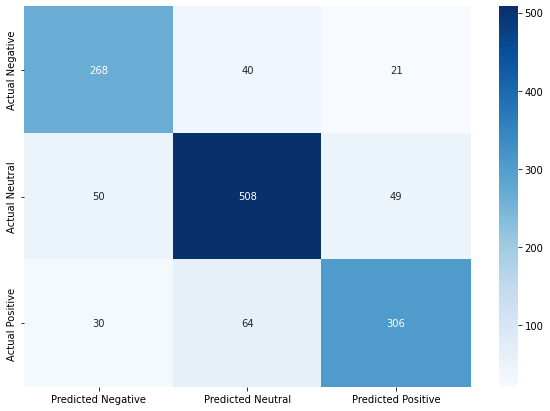

In [127]:
result = confusion_matrix(test_labels_ls, predicted_labels_ls)
cf_matrix = pd.DataFrame(result, 
                                columns = ["Predicted Negative", "Predicted Neutral", "Predicted Positive"], 
                                index = ["Actual Negative", "Actual Neutral", "Actual Positive"])
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, 
           annot=True, 
           cmap='Blues', 
           fmt='.3g')
plt.show()

### F1 Score

In [128]:
print(f1_score(test_labels_ls, predicted_labels_ls, average = "macro"))
print(f1_score(test_labels_ls, predicted_labels_ls, average = "micro"))
print(f1_score(test_labels_ls, predicted_labels_ls, average = "weighted"))

0.8046193546472176
0.8098802395209581
0.8097745691328841


## Precision

In [129]:
print(precision_score(test_labels_ls, predicted_labels_ls, average = "macro"))
print(precision_score(test_labels_ls, predicted_labels_ls, average = "micro"))
print(precision_score(test_labels_ls, predicted_labels_ls, average = "weighted"))

0.8046700297466342
0.8098802395209581
0.81044117079954


#3 Recall

In [130]:
print(recall_score(test_labels_ls, predicted_labels_ls, average = "macro"))
print(recall_score(test_labels_ls, predicted_labels_ls, average = "micro"))
print(recall_score(test_labels_ls, predicted_labels_ls, average = "weighted"))

0.8054974887708247
0.8098802395209581
0.8098802395209581


## Training and Validation Loss Graph each epoch

5


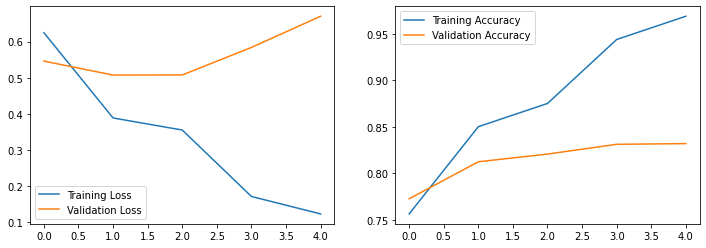

<Figure size 432x288 with 0 Axes>

In [131]:
losses = train_losses
accs = train_accs
val_losses = val_losses
val_accs = val_accs
epochs = len(losses)
print(epochs)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert__SPC_accuracy.png')